In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
from utils import accuracy_fn, print_time
from timeit import default_timer as timer

In [4]:
my_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
my_device

device(type='cuda')

In [5]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


In [6]:
BATCH_SIZE = 32

## Data

### Download and View

In [7]:
train_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=ToTensor()
)


test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
len(train_data), len(test_data)

(50000, 10000)

In [9]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [11]:
def imshow(img: torch.Tensor, label: str) -> None:
    plt.title(label)
    plt.imshow(torch.permute(img, (1, 2, 0)))

In [12]:
image, label = train_data[0]

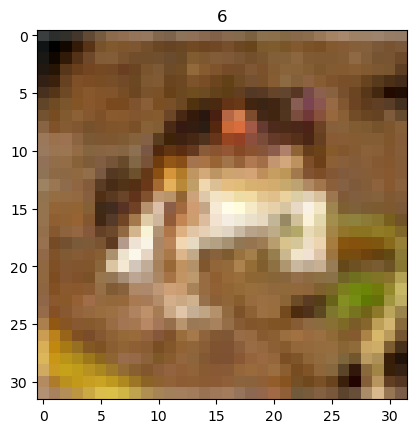

In [13]:
imshow(image, label)

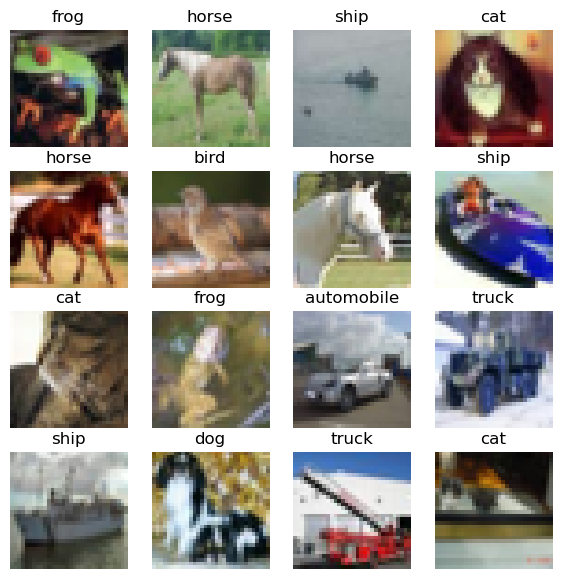

In [14]:
torch.manual_seed(42)

fig = plt.figure(figsize=(7, 7))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=(1,)).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    imshow(img, class_names[label])
    plt.axis(False)

In [15]:
# Example: Retrieve the first image from the dataset
image, label = train_data[0]

# Print the normalized image and label
print(f"Normalized Image shape: {image.shape}")
print(f"Label: {label}")

Normalized Image shape: torch.Size([3, 32, 32])
Label: 6


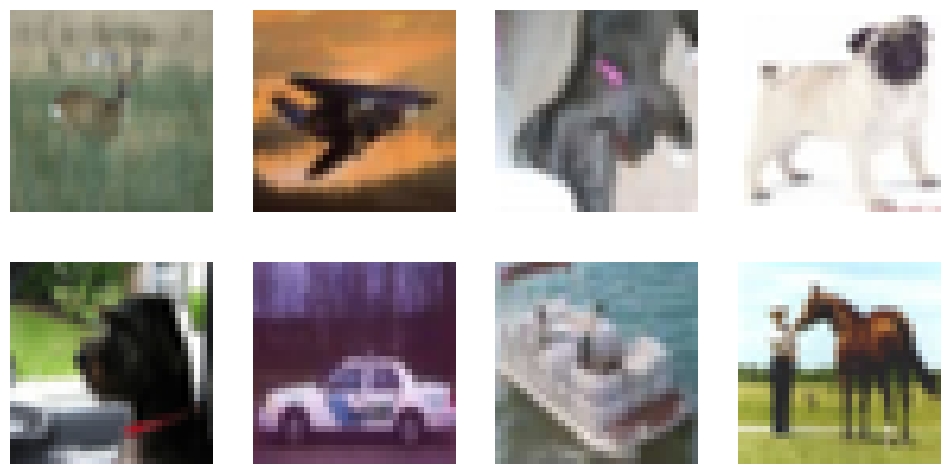

In [16]:
# Create DataLoader for batching
example_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)


# Visualize a batch of augmented images to inspect the augmentations
def visualize_batch():
    data_iter = iter(example_loader)
    images, labels = next(data_iter)

    # Plot a batch of 8 images
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(8):
        ax = axes[i // 4, i % 4]
        ax.imshow(images[i].permute(1, 2, 0).numpy())
        ax.axis("off")
    plt.show()


# Call the function to visualize a batch of augmented images
visualize_batch()

### Dataloaders

In [17]:
from torch.utils.data import DataLoader

In [18]:
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [20]:
len(train_dataloader) * BATCH_SIZE, len(test_dataloader) * BATCH_SIZE

(50016, 10016)

In [21]:
# let's look at one of the training batches
features_batch, labels_batch = next(iter(train_dataloader))
features_batch.shape, labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

## Base Model

In [22]:
from model import BaseModel

In [23]:
base_model = BaseModel().to(device=my_device)
base_model.load_state_dict(torch.load("models/best_model.pt", weights_only=True))
base_model

BaseModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (log_softmax): LogSoftmax(dim=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [24]:
from torchinfo import summary

summary(base_model, input_size=features_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
BaseModel                                [32, 10]                  --
├─Conv2d: 1-1                            [32, 16, 32, 32]          448
├─ReLU: 1-2                              [32, 16, 32, 32]          --
├─MaxPool2d: 1-3                         [32, 16, 16, 16]          --
├─Conv2d: 1-4                            [32, 32, 16, 16]          4,640
├─ReLU: 1-5                              [32, 32, 16, 16]          --
├─MaxPool2d: 1-6                         [32, 32, 8, 8]            --
├─Conv2d: 1-7                            [32, 64, 8, 8]            18,496
├─ReLU: 1-8                              [32, 64, 8, 8]            --
├─MaxPool2d: 1-9                         [32, 64, 4, 4]            --
├─Flatten: 1-10                          [32, 1024]                --
├─Dropout: 1-11                          [32, 1024]                --
├─Linear: 1-12                           [32, 512]                 524,800
├─

In [25]:
criterion = nn.NLLLoss()

In [26]:
base_model.eval()
test_loss, test_acc = 0, 0
time_start = timer()

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(my_device), y.to(my_device)
        y_pred = base_model.forward(X)
        mean_batch_loss: torch.Tensor = criterion(y_pred, y)
        test_loss += mean_batch_loss.item()
        test_acc += accuracy_fn(y, torch.argmax(y_pred, dim=1))

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)

print(f"test loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")

time_end = timer()
total_train_time = print_time("Inference", time_start, time_end, my_device)

test loss: 0.5886 | test_acc: 80.53%

Inference time on cuda: 0.794 seconds


## Evaluation

### Loss & Accuracy Plots

In [27]:
test_loss = 0.0
class_correct = np.zeros(10)
class_total = np.zeros(10)

base_model.eval()
for X, y in test_dataloader:
    X, y = X.to(my_device), y.to(my_device)
    with torch.inference_mode():
        output = base_model(X)
    loss = criterion(output, y)
    test_loss += loss.item() * X.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(y.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i, _ in enumerate(correct):
        label = int(y.data[i])
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_dataloader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                class_names[i],
                100 * class_correct[i] / class_total[i],
                class_correct[i],
                class_total[i],
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (class_names[i]))

correct = np.sum(class_correct, dtype=int)
total = np.sum(class_total, dtype=int)
print(f"\nTest Accuracy (Overall): {100.0 * correct / total}% ({correct}/{total})")

Test Loss: 0.588737

Test Accuracy of airplane: 84% (848/1000)
Test Accuracy of automobile: 90% (906/1000)
Test Accuracy of  bird: 69% (699/1000)
Test Accuracy of   cat: 61% (619/1000)
Test Accuracy of  deer: 79% (793/1000)
Test Accuracy of   dog: 73% (732/1000)
Test Accuracy of  frog: 85% (857/1000)
Test Accuracy of horse: 84% (841/1000)
Test Accuracy of  ship: 88% (889/1000)
Test Accuracy of truck: 87% (870/1000)

Test Accuracy (Overall): 80.54% (8054/10000)


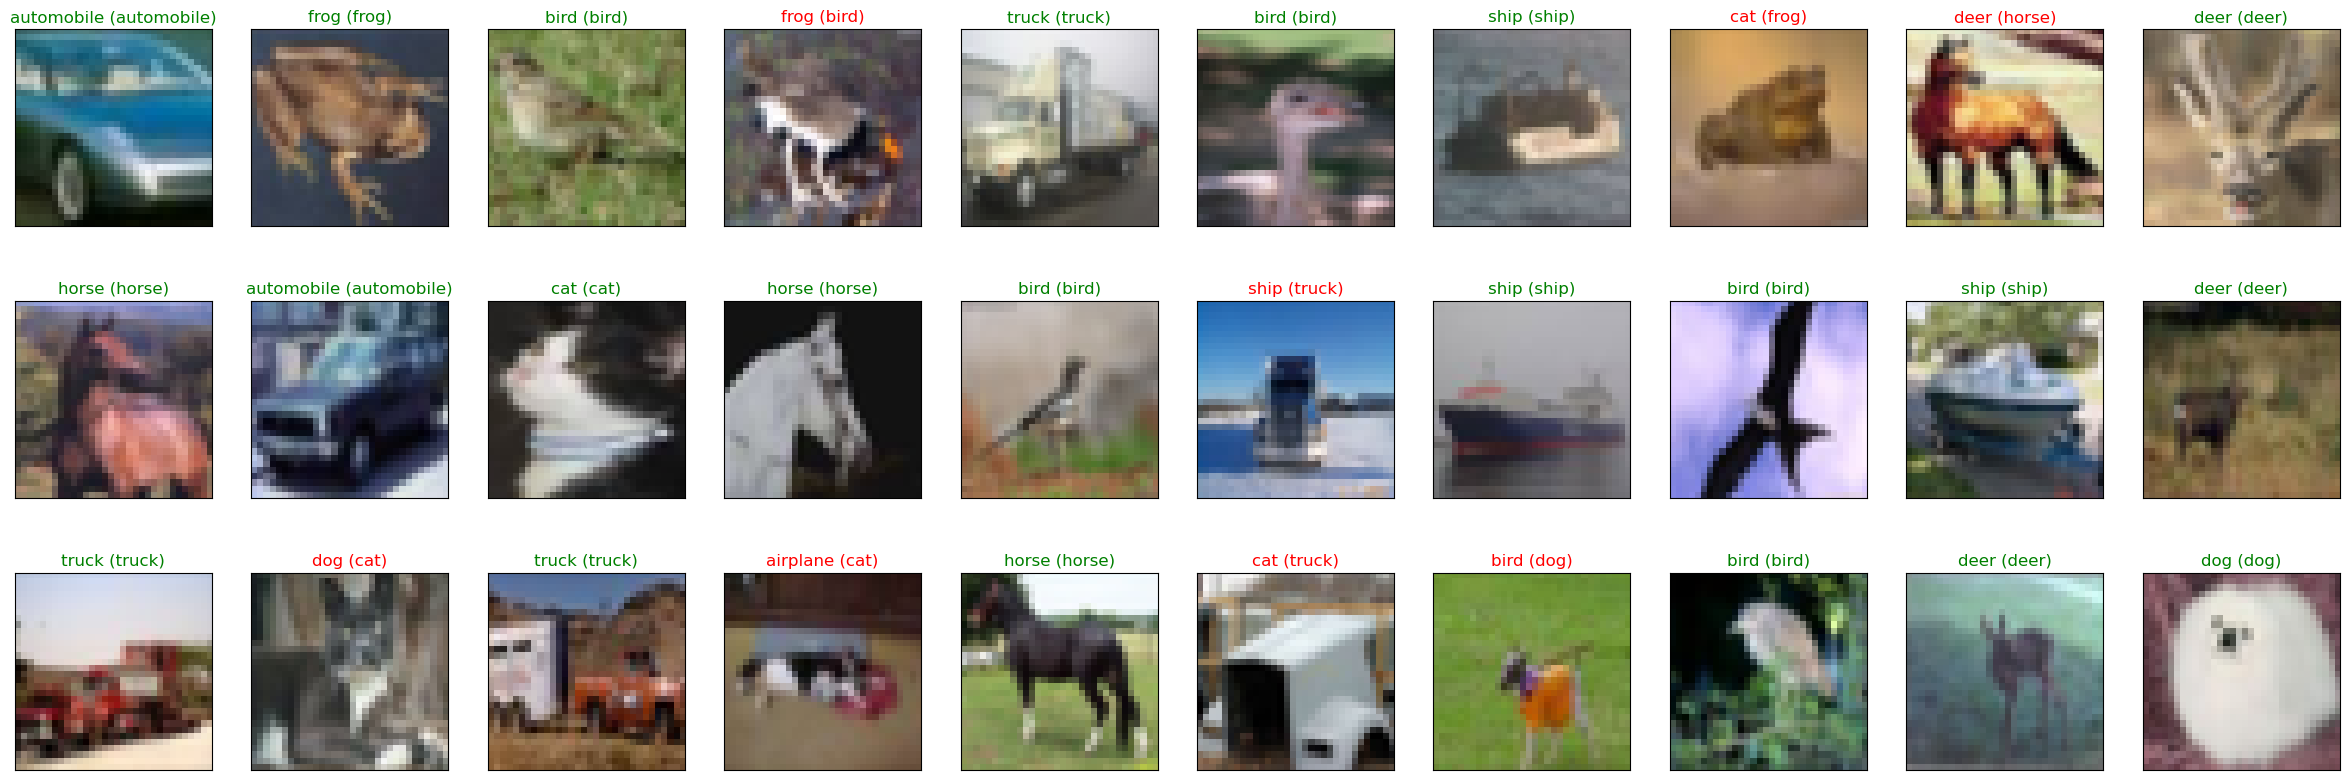

In [28]:
example_size = 30
example_loader = DataLoader(test_data, batch_size=example_size, shuffle=True)
dataiter = iter(example_loader)
images, labels = next(dataiter)
images.numpy()

with torch.inference_mode():
    output = base_model(images.to(my_device))

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(30, 10))
for idx in np.arange(example_size):
    ax = fig.add_subplot(3, 10, idx + 1, xticks=[], yticks=[])
    imshow(images[idx], labels[idx])
    ax.set_title(
        "{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
        color=("green" if preds[idx] == labels[idx].item() else "red"),
    )

## Student Model

### Knowledge Distillation

Knowledge distillation is a technique to transfer knowledge from a large, pre-trained model (teacher model) to a smaller model (student model). The goal is to achieve a similar level of performance with a more compact model, which is often more efficient for deployment.

In this section, we will implement knowledge distillation by building and training a smaller student model using the `base_model` as the teacher model.

In [1]:
from model import StudentModel, SmallStudentModel

In [29]:
# Instantiate the student model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# student_model = SmallStudentModel().to(my_device)
student_model = StudentModel().to(my_device)

In [30]:
summary(student_model, input_size=features_batch.shape)

Layer (type:depth-idx)                   Output Shape              Param #
StudentModel                             [32, 10]                  --
├─Conv2d: 1-1                            [32, 16, 32, 32]          448
├─ReLU: 1-2                              [32, 16, 32, 32]          --
├─MaxPool2d: 1-3                         [32, 16, 16, 16]          --
├─Conv2d: 1-4                            [32, 32, 16, 16]          4,640
├─ReLU: 1-5                              [32, 32, 16, 16]          --
├─MaxPool2d: 1-6                         [32, 32, 8, 8]            --
├─Conv2d: 1-7                            [32, 64, 8, 8]            18,496
├─ReLU: 1-8                              [32, 64, 8, 8]            --
├─MaxPool2d: 1-9                         [32, 64, 4, 4]            --
├─Flatten: 1-10                          [32, 1024]                --
├─Linear: 1-11                           [32, 128]                 131,200
├─ReLU: 1-12                             [32, 128]                 --
├─

In [ ]:
def distillation_loss(
    y_student: torch.Tensor,
    y_teacher: torch.Tensor,
    y_true: torch.Tensor,
    alpha: float = 0.5,
    temperature: float = 2.0,
) -> torch.Tensor:
    distillation_loss = nn.KLDivLoss(reduction="batchmean")(
        nn.functional.log_softmax(y_student / temperature, dim=1),
        nn.functional.softmax(y_teacher / temperature, dim=1),
    ) * (temperature**2)
    student_loss = criterion(y_student, y_true)
    return alpha * distillation_loss + (1 - alpha) * student_loss

In [66]:
epochs = 10
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3, weight_decay=5e-4)
# optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# scheduler = None

In [67]:
best_test_acc = 0
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
lr_list = []
alpha = 0.4
temperature = 2.0

In [ ]:
for epoch in range(epochs):
    print("epoch:", epoch)
    student_model.train()
    train_loss, train_acc = 0, 0

    for X, y in train_dataloader:
        X, y = X.to(my_device), y.to(my_device)

        with torch.inference_mode():
            y_teacher = base_model.forward(X)

        y_pred = student_model.forward(X)
        mean_batch_loss = distillation_loss(
            y_pred, y_teacher, y, alpha=alpha, temperature=temperature
        )
        train_loss += mean_batch_loss.item()
        train_acc += accuracy_fn(y, torch.argmax(y_pred, dim=1))
        optimizer.zero_grad()
        mean_batch_loss.backward()
        optimizer.step()

    if scheduler is not None:
        scheduler.step()

    train_loss /= len(train_dataloader)  # loss per batch
    train_acc /= len(train_dataloader)  # accuracy per batch
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    lr_list.append(optimizer.param_groups[0]["lr"])

    print(f"train loss: {train_loss:.4f} | train_acc: {train_acc:.2f}%")

    student_model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(my_device), y.to(my_device)
            y_pred = student_model.forward(X)
            mean_batch_loss: torch.Tensor = criterion(y_pred, y)
            test_loss += mean_batch_loss.item()
            test_acc += accuracy_fn(y, torch.argmax(y_pred, dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(
            student_model.state_dict(),
            f"models/best_student_model_{alpha}_{temperature}.pt",
        )

    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"test loss: {test_loss:.4f} | test_acc: {test_acc:.2f}%")
    print()

train_time_end = timer()
print("Best test accuracy: ", best_test_acc)
total_train_time = print_time("Train", time_start, train_time_end, my_device)

epoch: 0
train loss: 2.4817 | train_acc: 39.15%
test loss: 1.3742 | test_acc: 49.30%

epoch: 1
train loss: 1.9006 | train_acc: 51.47%
test loss: 1.2450 | test_acc: 56.43%

epoch: 2
train loss: 1.6424 | train_acc: 57.06%
test loss: 1.0936 | test_acc: 61.15%

epoch: 3
train loss: 1.4484 | train_acc: 61.16%
test loss: 1.0275 | test_acc: 64.47%

epoch: 4
train loss: 1.3047 | train_acc: 64.51%
test loss: 0.9757 | test_acc: 65.94%

epoch: 5
train loss: 1.1968 | train_acc: 66.70%
test loss: 0.9256 | test_acc: 68.02%

epoch: 6
train loss: 1.1123 | train_acc: 68.78%
test loss: 0.9145 | test_acc: 68.43%

epoch: 7
train loss: 1.0451 | train_acc: 70.42%
test loss: 0.8822 | test_acc: 69.86%

epoch: 8
train loss: 1.0079 | train_acc: 70.99%
test loss: 0.8627 | test_acc: 70.11%

epoch: 9
train loss: 0.9756 | train_acc: 72.02%
test loss: 0.8480 | test_acc: 70.59%

Best test accuracy:  70.5870607028754

Train time on cuda: 86.603 seconds


## Eval

In [ ]:
# loaded_model = StudentModel().to(device=my_device)
# loaded_model.load_state_dict(
#     torch.load(f"models/best_student_model_{alpha}_{temperature}.pt", weights_only=True)
# )
# loaded_model

In [ ]:
loaded_model = StudentModel().to(device=my_device)
loaded_model.load_state_dict(
    torch.load(f"models/best_student_model_0.65_2.0_78.65.pt", weights_only=True)
)
loaded_model

StudentModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (log_softmax): LogSoftmax(dim=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [ ]:
test_loss = 0.0
class_correct = np.zeros(10)
class_total = np.zeros(10)

loaded_model.eval()
for X, y in test_dataloader:
    X, y = X.to(my_device), y.to(my_device)
    with torch.inference_mode():
        output = loaded_model(X)
    loss = criterion(output, y)
    test_loss += loss.item() * X.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(y.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i, _ in enumerate(correct):
        label = int(y.data[i])
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_dataloader.dataset)
print("Test Loss: {:.6f}\n".format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print(
            "Test Accuracy of %5s: %2d%% (%2d/%2d)"
            % (
                class_names[i],
                100 * class_correct[i] / class_total[i],
                class_correct[i],
                class_total[i],
            )
        )
    else:
        print("Test Accuracy of %5s: N/A (no training examples)" % (class_names[i]))

correct = np.sum(class_correct, dtype=int)
total = np.sum(class_total, dtype=int)
print(f"\nTest Accuracy (Overall): {100.0 * correct / total}% ({correct}/{total})")

Test Loss: 0.651073

Test Accuracy of airplane: 82% (823/1000)
Test Accuracy of automobile: 89% (895/1000)
Test Accuracy of  bird: 67% (679/1000)
Test Accuracy of   cat: 61% (618/1000)
Test Accuracy of  deer: 76% (765/1000)
Test Accuracy of   dog: 68% (688/1000)
Test Accuracy of  frog: 85% (858/1000)
Test Accuracy of horse: 79% (799/1000)
Test Accuracy of  ship: 87% (877/1000)
Test Accuracy of truck: 86% (863/1000)

Test Accuracy (Overall): 78.65% (7865/10000)
